# report 淘宝用户行为分析

## 背景
<br>
2014年见证了阿里巴巴集团电子商务业务的快速发展。例如，2014年11月11日出售的移动终端的总商品量（GMV）占GMV总量的42.6％。与PC时代相比，移动终端上的网络访问可以随时随地进行。此外，他们拥有更丰富的背景数据，如用户的位置信息，访问时间的规律性等。本次分析旨在从用户行为等各方面深入数据背后的深层含义，为运营团队在正确的时间和地点为移动端用户推荐合适的商品提供数据支持。

### 数据集描述

该数据集包含12256906行，6列，数据为淘宝APP2014年11月18日至2014年12月18日的用户行为数据，用户数量10000。<br>
数据l来源：天池数据集<br>
列字段包含以下：<br>
user_id：用户身份<br>
item_id：商品ID<br>
behavior_type：用户行为类型（包含点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示）<br>
user_geohash：地理位置<br>
item_category：品类ID（商品所属的品类）<br>
time：用户行为发生的时间

### 数据预处理

In [1]:
# 导入数据分析常用库、包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 可视化中显示中文黑体，显示负数
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [2]:
# 加载csv数据
df = pd.read_csv('mobile_recommend_train_user.csv')
#查看数据前五行
df.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


In [3]:
# 查看数据属性
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12256906 entries, 0 to 12256905
Data columns (total 6 columns):
user_id          int64
item_id          int64
behavior_type    int64
user_geohash     object
item_category    int64
time             object
dtypes: int64(4), object(2)
memory usage: 561.1+ MB


共有12256906条数据，时间序列是object，而且包含了日期与时间，需要进行转换。<br>
先用下列函数判断是否有缺失值:

In [4]:
# 查看各列是否有缺失值（False代表无缺失，True代表有缺失）
df.isnull().any(axis=0)

user_id          False
item_id          False
behavior_type    False
user_geohash      True
item_category    False
time             False
dtype: bool

In [5]:
# 计算缺失值行数
df.isnull().any(axis=1).sum()

8334824

发现缺失值都是地理位置信息，并且缺失量特别大，另外由于地理信息经过经纬度转换，所以难以研究，不做本次分析。

In [6]:
# 查看唯一值数量
df.nunique()

user_id            10000
item_id          2876947
behavior_type          4
user_geohash      575458
item_category       8916
time                 744
dtype: int64

了解到数据集包含10000名用户对于8916个品类下287万商品操作的记录。

In [7]:
# 时间序列数据类型转换
# 先进行日期和小时的切分
date = df['time'].map(lambda x:x.split(' ')[0])
hour = df['time'].map(lambda x:x.split(' ')[1])
#将拆分后的列增加到Dataframe中
df['date'] = date
df['hour'] = hour


In [8]:
# 日期类型转换 
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['hour'] = df.hour.astype(np.int64)
df['time'] = pd.to_datetime(df['time'],format='%Y-%m-%d %H')


In [9]:
# 将object 转换为字符串
def convert_to_str(df,columns):
    for i in columns:
        df[i]=df[i].values.astype('str')
    return df
df=convert_to_str(df,['user_id','item_id','item_category'])

## 用户行为分析

### 1.PV和UV分析

- 日PV和UV趋势分析
- 各时间段PV和UV趋势分析
- 各时间段用户行为趋势分析

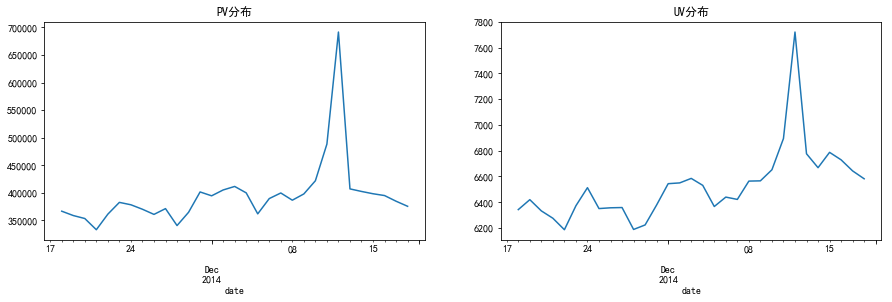

In [10]:
# 按照日期分组，计算pv uv 
grouped_date = df.groupby('date')
pv_date = grouped_date['user_id'].count()
uv_date = grouped_date['user_id'].apply(lambda x:x.drop_duplicates().count())

plt.figure(figsize = (15,4))
plt.subplot(121)
pv_date.plot()
plt.title('PV分布')
plt.subplot(122)
uv_date.plot()
plt.title('UV分布')
plt.show()

可以看到，PV和UV差距较大，但趋势基本一致，趋于稳定。受“双十二”活动影响，12月11日-12月13日PV和UV均有增长，在“双十二”当天增长显著。<br>
从UV上看，因为本数据集用户数量10000人，日活维持在60%以上。

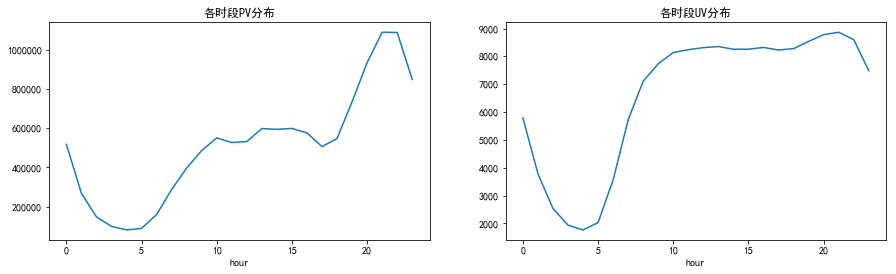

In [11]:
#按时间段分组，计算时间段PV和UV分析，分析曲线
grouped_hour = df.groupby('hour')
pv_hour = grouped_hour['user_id'].count()
uv_hour = grouped_hour['user_id'].apply(lambda x:x.drop_duplicates().count())

plt.figure(figsize = (15,4))
plt.subplot(121)
pv_hour.plot()
plt.title('各时段PV分布')
plt.subplot(122)
uv_hour.plot()
plt.title('各时段UV分布')
plt.show()

可以看到，0-18时PV和UV的趋势相似，凌晨2点-5点之间访问量最低;<br>
但是18点左右开始到22点这个时间段内，uv波动不大，而pv波动巨大，说明该时段是对app操作最频繁的时间段，我们可以将pv用户行为进行细分查看。

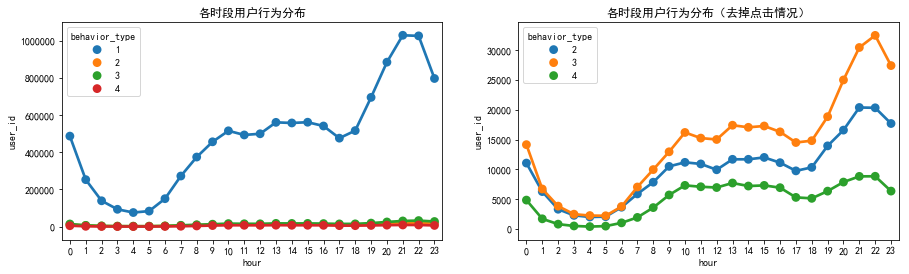

In [12]:
# 用户行为分析（1-点击，2-收藏，3-加购，4-支付）
pv_behavior = df.groupby(['behavior_type','hour'])['user_id'].count().reset_index()

plt.figure(figsize =(15,4))
plt.subplot(121)
sns.pointplot(x='hour',y='user_id',hue='behavior_type',data=pv_behavior)
plt.title('各时段用户行为分布')
plt.subplot(122)
sns.pointplot(x='hour',y='user_id',hue='behavior_type',data=pv_behavior[pv_behavior.behavior_type!=1])
plt.title('各时段用户行为分布（去掉点击情况）')
plt.show()


可以看出点击情况远远超出比其他三类行为;<br>
四种行为趋势随时间的波动基本一致，结合上述分析可以判断：用户在晚上（18点到24点）这个时间段会有更多的使用行为。<br>
从第二张图还可以看出加入购物车的行为要多于收藏行为。

### 2.用户消费趋势分析
**（本次数据没有消费金额，无法分析ARPU，因此只从消费次数角度分析）**
- 每日消费总次数
- 每日消费用户数
- 每日人均消费次数

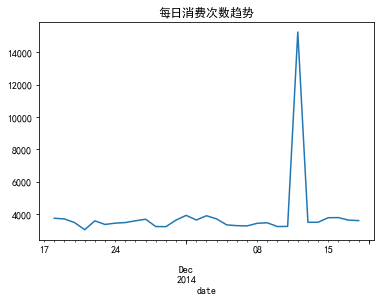

In [13]:
# 将支付行为用户按照日期和用户id分组，得出每日每个用户消费次数
grouped_pay = df[df.behavior_type==4].groupby(['date','user_id'])['behavior_type'].count().reset_index()
# 再按照日期分组，得出每日用户消费总次数
pay_count = grouped_pay.groupby('date')['behavior_type'].sum()
pay_count.plot()
plt.title('每日消费次数趋势')
plt.show()

每日消费次数基本稳定在2000-4000次，“双十二”当天突破了15000次

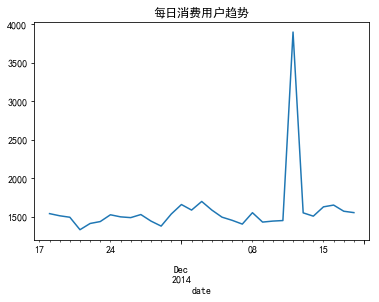

In [14]:
# 计算每日消费用户数
pay_user = grouped_pay.groupby('date')['behavior_type'].count()
pay_user.plot()
plt.title('每日消费用户趋势')
plt.show()

每日消费用户基本在750-1800之间波动，“双十二”当天有近4000人支付。

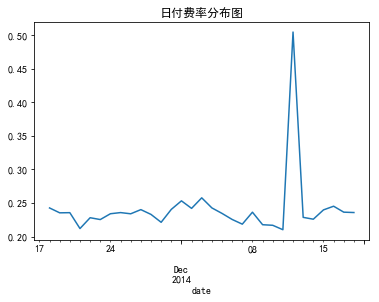

In [20]:
# 付费率 = 消费用户数/活跃用户数（有操作行为的用户数）
grouped_tub =df.groupby(['date','user_id','behavior_type'])['item_id'].count().reset_index()
pay_rate = grouped_tub.groupby('date').apply(lambda x:x[x.behavior_type==4].item_id.count()/len(x.user_id.unique()))
pay_rate.plot()
plt.title('日付费率分布图')
plt.show()

基本每天付费率在0.2-0.25之间，即日活中有20%-25%的有购买行为。

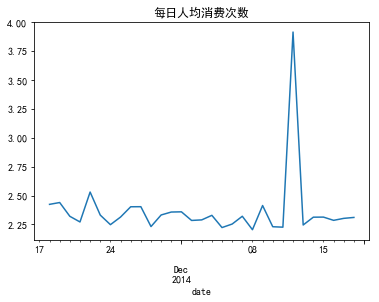

In [21]:
#人均消费次数
grouped_pay.groupby('date').apply(lambda x:x.behavior_type.sum()/x.behavior_type.count()).plot()
plt.title('每日人均消费次数')
plt.show()

从人均消费次数上看，基本在2-2.5次区间波动，即使是双十二活动前一天，也在此范围内。大促并没有对平时购物造成太大影响。

### 3.用户个体消费分析
**（本次数据没有消费金额，因此只能从消费次数角度分析）**
- 用户消费次数的描述统计
- 用户消费次数分布图

In [22]:
# 每个用户消费次数情况
grouped_user = df[df.behavior_type==4].groupby('user_id')
# 用户消费次数的描述统计
grouped_user.count().describe()

,item_id,behavior_type,user_geohash,item_category,time,date,hour
count,8886.000000,8886.000000,8886.000000,8886.000000,8886.000000,8886.000000,8886.000000
mean,13.527459,13.527459,4.344812,13.527459,13.527459,13.527459,13.527459
std,19.698786,19.698786,10.185270,19.698786,19.698786,19.698786,19.698786
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,0.000000,4.000000,4.000000,4.000000,4.000000
50%,8.000000,8.000000,1.000000,8.000000,8.000000,8.000000,8.000000
75%,17.000000,17.000000,5.000000,17.000000,17.000000,17.000000,17.000000
max,809.000000,809.000000,458.000000,809.000000,809.000000,809.000000,809.000000


描述统计中可以看出，10000个用户中有8886个用户在这一个月中购买了商品，这个月平均每个用户消费13.5次，中位数是8次，而最多消费次数的用户消费了809次，说明属于极值。

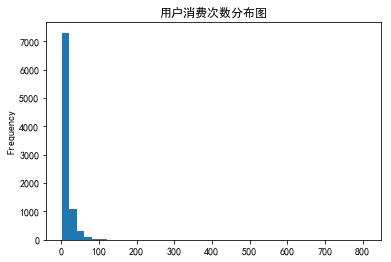

In [23]:
# 用户消费次数分布图
grouped_user.behavior_type.count().plot.hist(bins=40)
plt.title('用户消费次数分布图')
plt.show()

可以看出一个月内用户消费次数基本在100次内，根据切比雪夫定理（95%的数据位于均值的5个标准差内）可以判断95%的用户的消费次数在1-115次。<br>
对于消费次数大于100次的用户，推断可能是在双十二当天贡献较多，可以对这部分用户进行具体分析。

### 4.用户消费行为分析

- 仅消费一次的用户数据
- RFM分析
- 漏斗流失分析
- 复购率

**1）仅消费一次的用户数据**

In [24]:
user_life = grouped_user.time.agg(['min','max'])
(user_life['min'] == user_life['max']).value_counts()

False    7919
True      967
dtype: int64

Ture 代表仅购买一次用户数，共计967人,占比10.9%，不是很高。

**2）RFM分析**<br>
<br>
RFM分析是根据客户活跃程度和交易金额的贡献，进行客户价值细分的一种方法。<br>
三个维度将用户分为八个类型。<br>
本次数据集没有销售金额，先建立rfm模型，分析R、F两个维度，有销售金额的数据可以直接利用模型<br>

In [25]:
rfm = df[df.behavior_type==4].pivot_table(index = 'user_id',
                                         values = ['date','behavior_type'],
                                         aggfunc = {'date':'max','behavior_type':'count'})  # 金额{'purchase' : 'sum'}

In [26]:
# 因为数据为2014年较为久远，最后一次消费用今天计算数值较大，因此此次取数据集中时间最大值作为标准
rfm['R'] = -(rfm.date - rfm.date.max())/np.timedelta64(1,'D')  # 转换格式为float
rfm.rename(columns = {'behavior_type':'F'},inplace = True)

# 设置函数  
def rfm_func(x):
    level = x.apply(lambda x:'1' if x>=0 else '0')  
    label = level.R +level.F       # +level.M    
    d = {'01':'价值客户',           # '011':'高价值客户'   '010':'一般价值客户'
        '11':'保持客户',            # '111':'重要保持客户' '110':'一般保持客户'
        '00':'发展客户',            # '001':'重要发展客户' '000':'一般发展客户'
        '10':'挽留客户'}            # '101':'重点挽留客户' '100':'潜在客户/一般挽留客户'
    result=d[label]
    return result

rfm['label'] = rfm[['R','F']].apply(lambda x:x-x.mean()).apply(rfm_func,axis=1)  # 以平均值作为参考标准。
rfm.groupby('label').count()      # 各级用户占比   如数据集中有销费金额，则可以用sum函数，查看各级用户消费金额占比

,F,date,R
label,,,
价值客户,2394,2394,2394
保持客户,451,451,451
发展客户,2986,2986,2986
挽留客户,3055,3055,3055


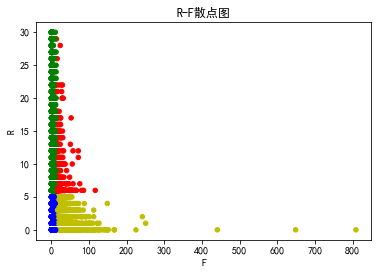

In [27]:
# 可视化
rfm.loc[rfm.label == '价值客户','color']='y'
rfm.loc[rfm.label == '保持客户','color']='r'
rfm.loc[rfm.label == '发展客户','color']='b'
rfm.loc[rfm.label == '挽留客户','color']='g'
rfm.plot.scatter('F','R',c = rfm.color)
plt.title('R-F散点图')
plt.show()

由于数据没有消费金额，因此缺少消费金额（M）这一列，只能对最近一次消费（R）和消费次数（F）两个维度建立模型。<br>
可以对RFM各级用户进行差异化营销，比如：<br>
重点关注保持客户<br>
对于价值客户，关注他们的购物习性做精准化营销<br>
对于发展客户，可以适当利用折扣或捆绑销售来增加用户的购买频率<br>

**3）漏斗流失分析**<br>
<br>
探索每天、每时段漏斗流失趋势,漏斗步骤为：点击-加购-支付 

In [28]:
# 总体流失率
geouped_behavior = df.groupby('behavior_type')['user_id'].count()
click_to_car_loss_rate =1-geouped_behavior[3]/geouped_behavior[1]
car_to_pay_loss_rate =1-geouped_behavior[4]/geouped_behavior[3]
print('click_to_car_loss_rate:',click_to_car_loss_rate)
print('car_to_pay_loss_rate:',car_to_pay_loss_rate)

click_to_car_loss_rate: 0.9702556953628566
car_to_pay_loss_rate: 0.6501234122317822


In [29]:
# 以日为单位计算漏斗流失
pivoted_date_behavior = df.pivot_table(index = 'date',
                                  columns = 'behavior_type',
                                  values = 'user_id',
                                  aggfunc = 'count').reset_index()
day_click_to_car=pivoted_date_behavior.apply(lambda x:1-x[3]/x[1],axis=1)       #点击到加购流失率
day_car_to_pay=pivoted_date_behavior.apply(lambda x:1-x[4]/x[3],axis=1)         #加购到支付流失率
day_loss_rates = pd.concat([pivoted_date_behavior['date'],day_click_to_car,day_car_to_pay],axis=1,ignore_index=True)
day_loss_rates.set_index([0], inplace=True)

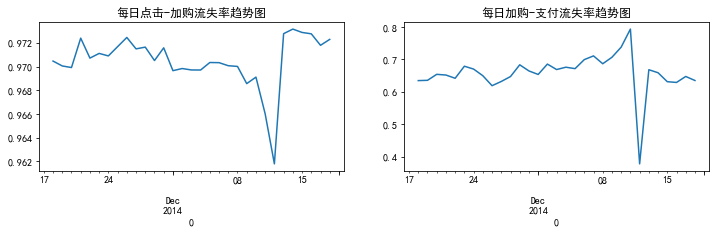

In [30]:
#可视化
plt.figure(figsize = (12,6))
plt.subplot(221)
day_loss_rates[1].plot()
plt.title('每日点击-加购流失率趋势图')
plt.subplot(222)
day_loss_rates[2].plot()
plt.title('每日加购-支付流失率趋势图')
plt.show()

可以看出:<br>
- 点击到加购流失率特别高，在95%以上，12月11日到13日这几天由于“双十二”大促流失率相对偏低；<br>
- 而加购到支付流失率除了双十二影响，基本在60%-80%，双十二降到了40%以下。<br>
- 从表现上看除去双十二影响，每天的流失率趋于稳定。

In [31]:
# 以时段为单位计算漏斗流失
pivoted_hour_behavior = df.pivot_table(index = 'hour',
                                  columns = 'behavior_type',
                                  values = 'user_id',
                                  aggfunc = 'count').reset_index()
hour_click_to_car=pivoted_hour_behavior.apply(lambda x:1-x[3]/x[1],axis=1)       #点击到加购流失率
hour_car_to_pay=pivoted_hour_behavior.apply(lambda x:1-x[4]/x[3],axis=1)         #加购到支付流失率
hour_loss_rates = pd.concat([pivoted_hour_behavior['hour'],hour_click_to_car,hour_car_to_pay],axis=1,ignore_index=True)
hour_loss_rates.set_index([0], inplace=True)

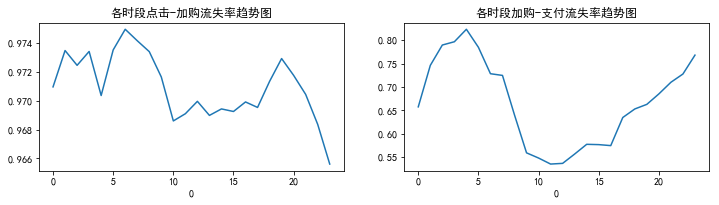

In [32]:
#可视化
plt.figure(figsize = (12,6))
plt.subplot(221)
hour_loss_rates[1].plot()
plt.title('各时段点击-加购流失率趋势图')
plt.subplot(222)
hour_loss_rates[2].plot()
plt.title('各时段加购-支付流失率趋势图')
plt.show()

可以看出：<br>
- 凌晨时间段点击到加购、加购到支付流失率都很高，推测用户在休息前随便查看下商品，产生支付的情况很少，或者预先加购第二天再支付。
- 白天时间段能够点击、加购的基本都是属于有意愿购买的，所以流失率相对较低。
- 晚上20点-23点这段时间，点击到加购流失率呈下降趋势，而同一时段支付流失呈上升趋势，可能这段时间用户有更多时间挑选、比较和思考是否要购买

**4) 复购率分析**<br>
<br>
复购指所有购买过产品的顾客，以每个人为独立单位重复购买产品的次数，不同产品分析复购的时间维度不同，包括周复购/月复购/季复购/年复购等。<br>
本次数据为一个月的数据，因此在本次分析复购率的时候简单计算这一个月用户两天以上有购买行为,一天多次购买算一次。<br>
复购率=有复购行为的用户数/有购买行为的用户总数

In [33]:
# 多月份销售数据 每月用户复购率计算方式
# df['month']=df['date'].values.astype('datatime64[M]')
# pivot_counts = df[df.behavior_type == 4].pivot_table(index ='user_id',
#                                                    columns = 'month',
#                                                   values = 'date',
#                                                    aggfunc = 'count').fillna(0)
#purchase_r = pivot_counts.applymap(lambda x:1 if x>1 else np.NaN if x==0 else 0)
#repurchase_rate = purchase_r.sum()/purchase_r.count()
#repurchase_rate

In [34]:
purchase_r=df[df.behavior_type==4].groupby('user_id')['date'].apply(lambda x:len(x.unique()))
repurchase_rate = purchase_r[purchase_r>=2].count()/purchase_r.count()
print('repurchase_rate:',repurchase_rate)

repurchase_rate: 0.8717083051991897


### 5.用户行为与商品类别的关系

- 商品类别购买次数情况
- 商品类别累计购买次数占比
- 不同商品类别加购和收藏比率
- 不同商品类别转化率

**1）商品类别购买次数情况**

In [35]:
# 有购买记录的商品品类的描述统计 
grouped_item_category = df[df.behavior_type==4].groupby('item_category')
grouped_item_category.item_id.count().describe()

count    4665.000000
mean       25.767417
std        92.559904
min         1.000000
25%         2.000000
50%         5.000000
75%        15.000000
max      2208.000000
Name: item_id, dtype: float64

- 在数据预处理时得知，数据集共有8916个商品分类，而从购买情况的描述统计中得知，共有4665个商品分类有购买行为，占比刚刚超过一半，且购买时间段包含了”双十二“大促，其他没有购买行为的商品分类需要深入研究没有购买的原因。
- 有购买行为的商品分类中，售出最少的分类仅1件，售出最多的分类共售出的2208件，平均售出25.8件，而中位数仅为5件，四分之三位数仅为15件，说明大多数品类售出情况并不理想。可以进一步通过累计购买次数分析。

/Users/yangle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


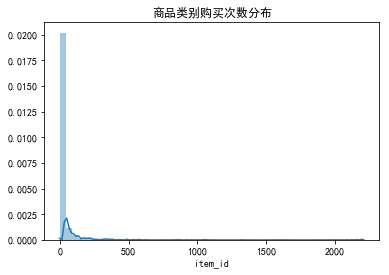

In [36]:
# 商品类别购买次数分布
sns.distplot(grouped_item_category.item_id.count())
plt.title('商品类别购买次数分布')
plt.show()

**2）各品类累计购买次数占比**

In [37]:
item_category_cumsum = grouped_item_category.count().sort_values(by='item_id').apply(lambda x:x.cumsum()/x.sum())
item_category_cumsum.head()

,user_id,item_id,behavior_type,user_geohash,time,date,hour
item_category,,,,,,,
642,0.000008,0.000008,0.000008,0.000026,0.000008,0.000008,0.000008
1271,0.000017,0.000017,0.000017,0.000026,0.000017,0.000017,0.000017
6559,0.000025,0.000025,0.000025,0.000052,0.000025,0.000025,0.000025
127,0.000033,0.000033,0.000033,0.000078,0.000033,0.000033,0.000033
12694,0.000042,0.000042,0.000042,0.000104,0.000042,0.000042,0.000042


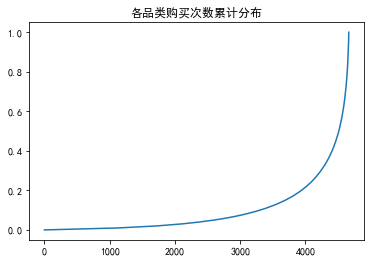

In [38]:
item_category_cumsum.reset_index().item_id.plot()
plt.title('各品类购买次数累计分布')
plt.show()

可以发现:
- 前80%销量有不到20%的品类包办，符合典型的二八定律。
- 而根据长尾理论，只要商品的流通的渠道足够大，需求不旺或销量不佳的商品所共同占据的市场份额可以和那些少数热销产品所占据的市场份额相匹敌甚至更大，而对于电商来讲，由于节省了空间成本，因此优化长尾部分的商品品类，提升这部分销量，将会带来更大收益。

**3）不同商品类别加购和收藏比率**

In [40]:
category_behavior = df.groupby(['item_category','behavior_type']).count().unstack(1).rename(columns={1:'click_count',2:'collect_count',3:'car_count',4:'pay_count'})

In [41]:
category_cvr = category_behavior.user_id.fillna(0)
category_cvr.head()

behavior_type,click_count,collect_count,car_count,pay_count
item_category,,,,
10,212.0,3.0,9.0,4.0
100,87.0,1.0,3.0,0.0
10000,18.0,0.0,0.0,0.0
10002,33.0,0.0,0.0,0.0
10010,1254.0,31.0,31.0,15.0


In [42]:
category_cvr['car_conversion_rate'] = category_cvr['car_count']/category_cvr['click_count']
category_cvr['collect_conversion_rate'] = category_cvr['collect_count']/category_cvr['click_count']
category_cvr.head()

behavior_type,click_count,collect_count,car_count,pay_count,car_conversion_rate,collect_conversion_rate
item_category,,,,,,
10,212.0,3.0,9.0,4.0,0.042453,0.014151
100,87.0,1.0,3.0,0.0,0.034483,0.011494
10000,18.0,0.0,0.0,0.0,0.000000,0.000000
10002,33.0,0.0,0.0,0.0,0.000000,0.000000
10010,1254.0,31.0,31.0,15.0,0.024721,0.024721


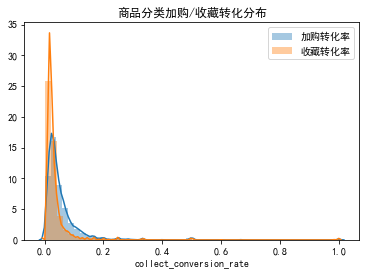

In [43]:
# 去除异常值 
category_cvr2 = category_cvr[category_cvr['car_conversion_rate']<=1]  #存在其他渠道购买等情况 因此会有转化率大于1 需要剔除
category_cvr3 = category_cvr[category_cvr['collect_conversion_rate']<=1]
sns.distplot(category_cvr2[category_cvr2['car_conversion_rate']>0]['car_conversion_rate'])     #去除转化率为0 的商品分类
sns.distplot(category_cvr3[category_cvr3['collect_conversion_rate']>0]['collect_conversion_rate'])
plt.title('商品分类加购/收藏转化分布')
plt.legend(('加购转化率','收藏转化率'))
plt.show()

几乎所有的商品分类的加购转化率都在0.1以内，几乎所有的商品分类的收藏转化率都在0.2以内。 说明绝大多数商品并不能引起用户兴趣，应该反思商品展示、推荐系统或者其他因素。

**4）不同商品类别转化率**

In [44]:
category_cvr['conversion_rate'] = category_cvr['pay_count']/category_cvr['click_count']
category_cvr.head()

behavior_type,click_count,collect_count,car_count,pay_count,car_conversion_rate,collect_conversion_rate,conversion_rate
item_category,,,,,,,
10,212.0,3.0,9.0,4.0,0.042453,0.014151,0.018868
100,87.0,1.0,3.0,0.0,0.034483,0.011494,0.000000
10000,18.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
10002,33.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
10010,1254.0,31.0,31.0,15.0,0.024721,0.024721,0.011962


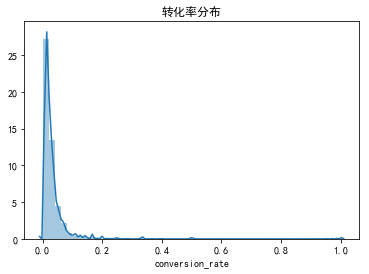

In [45]:
# 去除异常值 
category_cvr=category_cvr[category_cvr['conversion_rate']<=1]       #存在其他渠道购买等情况 因此会有转化率大于1 需要剔除
sns.distplot(category_cvr[category_cvr['conversion_rate']>0]['conversion_rate'])       #去除转化率为0 的商品分类
plt.title('转化率分布')
plt.show()

因为上述商品分类购买次数分析时，得出近半数的分类没有购买记录。<br>
而有购买记录的商品分类中，同加购转化率一样，除了个别的点击到支付的转化率稍高，绝大多数转化率都在0.1以内<br>
可以深度挖掘用户对半数商品分类不感兴趣的原因

## 总结


1. 通过pv，uv的不同时间维度分析，可以发现pv,uv随着时间呈现周期性变化，因此在做商品推广和广告营销尽量选择活跃度比较高的时间段会有更好效果。
2. 大部分人群消费次数在1-115次之间，对于大于115次消费的用户可以重点关注，是否由于活动促销原因，如果每月消费次数都很平稳，则需要重点关注维护。
3. 通过对用户的RFM模型分析，可以有效对不同用户进行不同群体划分，不同群体采用不同的个性化营销手段，能产生更好的效益。
4. 整体漏斗流失率较高，通过不同时间漏斗转化分析出流失率比较低的时间段，在这些时间段进行相应的商品推荐效果更优。。
5. 商品分类中，有近半数的分类没有购买记录，前80%销量有不到20%的品类包办，符合典型的二八定律。而电商零售摆脱了地域和空间的限制，应充分利用长尾理论来提高销量。重点关注转化率为0的分类。



